In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow

os.listdir()

['sample_submission.csv',
 'ff kNN.ipynb',
 'EDA and LSTM tf.ipynb',
 'test.zip',
 'unet_resnet_pytorch.ipynb',
 'train',
 'depths.csv',
 'train.zip',
 '.ipynb_checkpoints',
 'unet_resnet_v0.model',
 'resnet_unet_v0.ipynb',
 'train.csv',
 'test',
 'EDA and LSTM.ipynb',
 'registryupload_1.csv',
 'unet_resnet_v0.csv',
 'kNN_results.csv',
 'registryupload_2.csv']

In [3]:
df1 = pd.read_csv('registryupload_1.csv')
df2 = pd.read_csv('registryupload_2.csv')

df = df1.append(df2).reset_index()

def extract_date(startdate):
    parts = startdate.split()
    return parts[0]



df["Date"] = pd.to_datetime(df.JobStartDate, format='%m/%d/%Y %H:%M:%S AM', errors = 'coerce', utc=False)
hard_date = datetime.date(1980,1,1)
df["days_from"] = df.Date - hard_date
df.days_from = df.days_from.dt.days

print("Full data shape:", df.shape)
print(df.dtypes)
df.head(5)

Full data shape: (143590, 24)
index                               int64
pKey                               object
JobStartDate                       object
JobEndDate                         object
APINumber                           int64
StateNumber                         int64
CountyNumber                        int64
OperatorName                       object
WellName                           object
Latitude                          float64
Longitude                         float64
Projection                         object
TVD                               float64
TotalBaseWaterVolume              float64
TotalBaseNonWaterVolume           float64
StateName                          object
CountyName                         object
FFVersion                           int64
FederalWell                          bool
IndianWell                           bool
Source                            float64
DTMOD                             float64
Date                       datetime64[ns]
days

,index,pKey,JobStartDate,JobEndDate,APINumber,StateNumber,CountyNumber,OperatorName,WellName,Latitude,...,TotalBaseNonWaterVolume,StateName,CountyName,FFVersion,FederalWell,IndianWell,Source,DTMOD,Date,days_from
0,0,f66add2e-8ea8-4843-9388-24725b5d37c1,5/19/1982 12:00:00 AM,5/19/1982 12:00:00 AM,49009219470000,49,9,"Chesapeake Operating, Inc.",WILLIAM VALENTINE 1,42.972810,...,NaN,WYOMING,CONVERSE,1,False,False,NaN,NaN,1982-05-19 12:00:00,869.0
1,1,95f0904c-2556-4912-9f5a-34913ba57625,2/7/1995 12:00:00 AM,2/7/1995 12:00:00 AM,49009228850000,49,9,"Chesapeake Operating, Inc.",LIZARD HEAD 1-8H RE,42.851470,...,NaN,WYOMING,CONVERSE,1,False,False,NaN,NaN,1995-02-07 12:00:00,5516.0
2,2,5a9513e7-b79f-4488-9f64-fa0960e595f3,6/11/1996 12:00:00 AM,6/11/1996 12:00:00 AM,42335355480000,42,335,Energen Resources Corporation,North Westbrook Unit/Well No. 3032,32.440260,...,NaN,Texas,Mitchell,1,False,False,NaN,NaN,1996-06-11 12:00:00,6006.0
3,3,36368c95-a097-40ea-bb9f-2b647de7b913,12/13/2001 12:00:00 AM,12/13/2001 12:00:00 AM,42395313840000,42,395,XTO Energy/ExxonMobil,Olene Reagan 3-1,31.257980,...,NaN,Texas,Robertson,1,False,False,NaN,NaN,2001-12-13 12:00:00,8017.0
4,4,d7fa1dbc-b688-4b2b-8a3c-29ff3887bbbe,9/22/2008 12:00:00 AM,9/22/2008 12:00:00 AM,37059247370000,37,59,CONSOL Energy Inc.,CNX3,39.893301,...,NaN,PA,Greene,1,False,False,NaN,NaN,2008-09-22 12:00:00,10492.0


In [4]:
# Remove rows where no water volume exists
df = df[df['TotalBaseWaterVolume'].notnull()]
df['Latitude'].replace(376223, np.nan, inplace=True)
df = df[df['Latitude'].notnull()]
df = df[df['Longitude'].notnull()]
df = df[df['TVD'].notnull()]
print("Data shape:", df.shape)
df.head()


Data shape: (113420, 24)


,index,pKey,JobStartDate,JobEndDate,APINumber,StateNumber,CountyNumber,OperatorName,WellName,Latitude,...,TotalBaseNonWaterVolume,StateName,CountyName,FFVersion,FederalWell,IndianWell,Source,DTMOD,Date,days_from
5,5,05e11984-99f4-4727-aebd-15f20e621316,11/19/2008 12:00:00 AM,11/19/2008 12:00:00 AM,37105214840000,37,105,Pennsylvania General Energy,Fisk Hollow PV PAD A #2146,41.847809,...,NaN,Pennsylvania,Potter,1,False,False,NaN,NaN,2008-11-19 12:00:00,10550.0
14,14,7ecb3f11-f69c-4957-9ee9-7ac5c9eadd05,6/29/2009 12:00:00 AM,6/29/2009 12:00:00 AM,37105215000000,37,105,Pennsylvania General Energy,Reed Run Keating PAD A #2145,41.728259,...,NaN,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-06-29 12:00:00,10772.0
15,15,41fa065f-1d8d-4e86-a21d-ce6d5fe89e77,7/7/2009 12:00:00 AM,7/7/2009 12:00:00 AM,37105212980000,37,105,Pennsylvania General Energy,Pine Hill #1941A,41.614847,...,NaN,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-07-07 12:00:00,10780.0
16,16,f98e67c5-8b7b-45b9-84d4-b4e5f2de6e86,7/13/2009 12:00:00 AM,7/13/2009 12:00:00 AM,37059251250000,37,59,Energy Corporation of America,Henderson King #2MH,39.883933,...,NaN,PA,Greene,1,False,False,NaN,NaN,2009-07-13 12:00:00,10786.0
18,18,6246ef12-8aca-47dc-9271-b93a21b9cd1c,8/3/2009 12:00:00 AM,8/3/2009 12:00:00 AM,37053290190000,37,53,Pennsylvania General Energy,Forest #2124,41.550398,...,NaN,Pennsylvania,Forest,1,False,False,NaN,NaN,2009-08-03 12:00:00,10807.0


In [5]:
import math

miles_per_lat = 69.172

df['lat_miles'] = df.Latitude * miles_per_lat
df['long_miles'] = df.Latitude.map(math.cos) * miles_per_lat
df['tvd_miles'] = df.TVD / 5280  # Assume that current TVD is in feet

print('New columns created to normalize to miles.')

New columns created to normalize to miles.


In [6]:
# Create train/test splits
feature_cols = ['lat_miles', 'long_miles', 'tvd_miles']
features = df[feature_cols]
labels = df['TotalBaseWaterVolume']

print('Features data frame shape:', features.shape)
print('Labels data frame shape:', labels.shape)

from sklearn.model_selection import train_test_split
# Take out 1% of data for testing

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.01, random_state=25)

# Reset indices
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)



Features data frame shape: (113420, 3)
Labels data frame shape: (113420,)
Training features shape: (112285, 3)
Test features shape: (1135, 3)


           RMSE   k
0  5.641451e+06   1
0  4.445504e+06   2
0  4.094920e+06   3
0  3.954400e+06   4
0  3.913516e+06   5
0  3.888105e+06   6
0  3.871932e+06   7
0  3.880179e+06   8
0  3.875533e+06   9
0  3.868833e+06  10


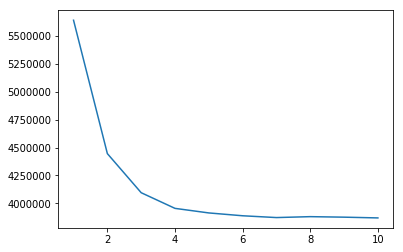

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

weights = 'distance'

compiled_results = pd.DataFrame(columns=['k', 'RMSE'])

for i in range(1, 11):    
    knn = KNeighborsRegressor(weights=weights, n_neighbors=i)
    knn.fit(X_train, y_train)
    results = knn.predict(X_test)
    rmse = math.sqrt(mean_squared_error(results, y_test))
    compiled_results = compiled_results.append(pd.DataFrame({'k': i, 'RMSE': rmse}, index=[0]))

x = compiled_results.k
y = compiled_results.RMSE
print(compiled_results.head(10))
plt.plot(x,y)

In [11]:
compiled_results.to_csv('kNN_rmse.csv', index=False)

i = 7
knn = KNeighborsRegressor(weights=weights, n_neighbors=i)
knn.fit(X_train, y_train)
results = knn.predict(X_test)
rmse = math.sqrt(mean_squared_error(results, y_test))

best_results = pd.DataFrame({'test': results, 'actual': y_test})

best_results.head()

best_results.to_csv('kNN_results.csv', index=False)